# TCN Classifier

Code inspiered:

https://de.mathworks.com/help/deeplearning/ug/sequence-to-sequence-classification-using-1-d-convolutions.html

References:

- [1] Bai, Shaojie, J. Zico Kolter, and Vladlen Koltun. “An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling.” Preprint, submitted April 19, 2018. https://arxiv.org/abs/1803.01271.

- [2] Oord, Aaron van den, Sander Dieleman, Heiga Zen, Karen Simonyan, Oriol Vinyals, Alex Graves, Nal Kalchbrenner, Andrew Senior, and Koray Kavukcuoglu. “WaveNet: A Generative Model for Raw Audio.” Preprint, submitted September 12, 2016. https://arxiv.org/abs/1609.03499.

- [3] Tompson, Jonathan, Ross Goroshin, Arjun Jain, Yann LeCun, and Christoph Bregler. “Efficient Object Localization Using Convolutional Networks.” 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 648–56. https://doi.org/10.1109/CVPR.2015.7298664.

In [23]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import sys
import numpy as np
import random
from sklearn.metrics import accuracy_score
import time
import json

sys.path.append('../scripts')
import ml_helper as mlh
import ml_evaluation as mle
import Tcnn
from Tcnn import TemporalConvNet

In [25]:
data_path = '../data'

In [26]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Choose organism

In [27]:
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]
organism = organisms[1]
print(f"Using organism: {organism}")

Using organism: E.Coli


### Set a Seed

In [28]:
SEED = 42
def set_seed(SEED=SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
set_seed()

### Data Preparation for training

In [29]:
pad_int = mlh.codons.index('___')
min_length = None
max_length = 500
one_hot = True
cut_data = False

SPEEDS_ADDED = False
BATCH_SIZE = 32

In [30]:
train_dataset = mlh.CodonDataset(organism, "train", min_length, max_length, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge train_dataset: {len(train_dataset)}")
test_dataset = mlh.CodonDataset(organism, "test", min_length, max_length, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge test_dataset: {len(test_dataset)}")
valid_dataset = mlh.CodonDataset(organism, "valid", min_length, max_length, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge valid_dataset: {len(valid_dataset)}")

Länge train_dataset: 3555
Länge test_dataset: 444
Länge valid_dataset: 420


In [31]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Hyperparameters and Model Initialization

Load best Hyperparamters

In [32]:
best_params = Tcn.load_best_params(organism)
if best_params is not None:
    print(f"Best parameters: num_filters: {best_params[0]}, filter_size: {best_params[1]}, dropout_factor: {best_params[2]}, num_blocks: {best_params[3]}, parallel_layer: {best_params[4]}, learing_rate: {best_params[5]}")

Best parameters: num_filters: 256, filter_size: 3, dropout_factor: 0.08, num_blocks: 3, parallel_layer: False, learing_rate: 0.001


In [33]:
# Hyperparameters
num_features = len(mlh.amino_acids)
num_classes = len(mlh.codons)
NUM_EPOCHS = 5

# Default values
num_filters = 128
# NOTE: filter size must be unequal like: 3,5,9,...
filter_size = 5#
dropout_factor = 0.008
num_blocks = 5
parallel_layer = True
learing_rate = 0.001 

if best_params is not None:
    num_filters = best_params[0]
    filter_size = best_params[1]
    dropout_factor = best_params[2]
    num_blocks = best_params[3]
    parallel_layer = best_params[4]
    learing_rate = best_params[5]


# Model
tcnModel = Tcnn.TemporalConvNet(num_features, num_classes, num_filters, filter_size, 
                        dropout_factor, num_blocks, parallel_layer)
print(tcnModel)

criterion = nn.CrossEntropyLoss(ignore_index=pad_int)
optimizer = optim.Adam(tcnModel.parameters(), lr=learing_rate)

TemporalConvNet(
  (layers): ModuleList(
    (0): Conv1d(22, 256, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.08, inplace=False)
    (5): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.08, inplace=False)
    (8): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.08, inplace=False)
    (12): Softmax(dim=1)
  )
)


### Start Training

In [34]:
trainings_losses, trainings_accuracies, valid_accs, best_epoch_idx = Tcn.train(tcnModel, train_loader, valid_loader, NUM_EPOCHS, optimizer, criterion, device=device)

Epoch [1/5], Loss: 5.23, accuracy: 0.471, valid acc: 0.539, time: 00:00:01
Epoch [2/5], Loss: 5.139, accuracy: 0.52, valid acc: 0.545, time: 00:00:01
Epoch [3/5], Loss: 5.105, accuracy: 0.523, valid acc: 0.545, time: 00:00:01
Epoch [4/5], Loss: 5.085, accuracy: 0.523, valid acc: 0.546, time: 00:00:01
Epoch [5/5], Loss: 5.072, accuracy: 0.523, valid acc: 0.546, time: 00:00:01
Training completed.
Best Validaton Accuracy: 0.5459852500162942


### Save the validation Accuracies into a JSON file

In [17]:
json_data = {'organism': organism, 'training_valid_accs': valid_accs, 'best_epoch_idx': best_epoch_idx}

# Save training valid accuracies
acc_path = data_path + f'/{organism}/training_valid_accs.json'

with open(acc_path, 'w') as file:
    json.dump(json_data, file)

print('Vaild Accs in training saved in:', acc_path)

Vaild Accs in training saved in: ../data/E.Coli/training_valid_accs.json


### Save the model

In [18]:
mlh.save_model(tcnModel, f'tcn_valid_acc_{round(round(valid_accs[-1],2) * 100)}', organism)

Model saved as 20240701191016_tcn_valid_acc_55.pt


### Load the model

In [19]:
tcnModel = mlh.load_model(f'tcn', organism, device=device)

Model loaded: 20240701191016_tcn_valid_acc_55.pt


## Plots

range(1, 21)


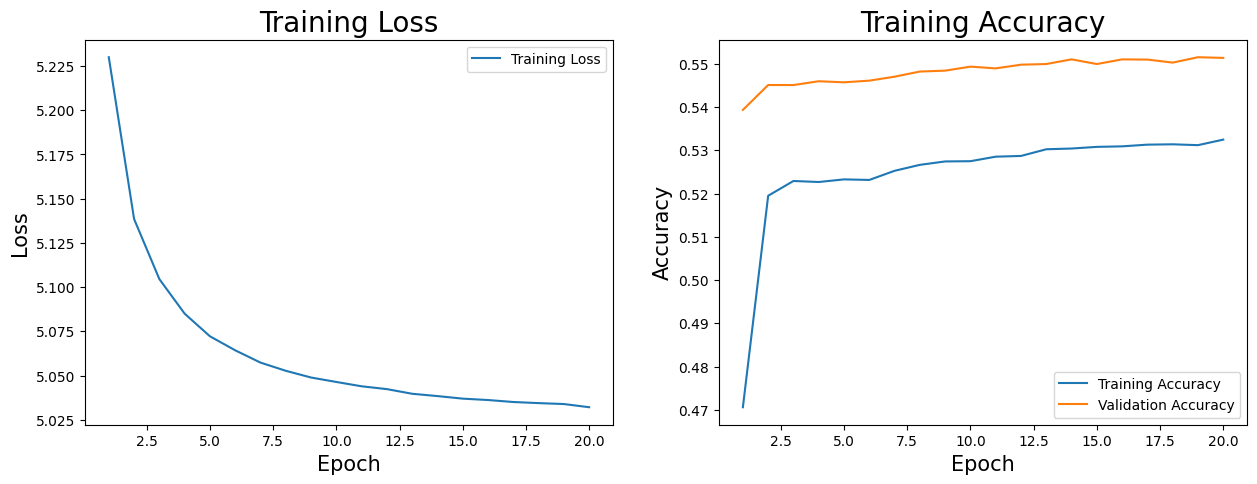

In [20]:
# check if training losses and accuracies is defined
if 'trainings_losses' in locals() and 'trainings_accuracies' in locals():
    # plot of training loss and accuracy
    plt = mle.plot_training(trainings_losses, trainings_accuracies, valid_accs)
    plt.show()
else:
    print("No training losses and accuracies available")

## Hyperparamter Grid Search

In [21]:
%%time

# Hyperparameters
params = {
    "num_filters": [64, 128, 256],
    "filter_size": [3, 5, 9],
    "dropout_factor": [0.08],
    "num_blocks": [3, 5, 7],
    "parallel_layer": [True, False],
    "learing_rate": [0.001]
}

# Hyperparameter search
#results, best_model = Tcn.hyperparam_search(organism, train_loader, valid_loader, params, num_features, num_classes, device, criterion)

CPU times: total: 0 ns
Wall time: 0 ns


### Save best model from grid search and the results of grid search

In [22]:
if 'results' in locals():
    for r in results[:10]:
        print(r)

    # print best parameters
    best_params = results[np.argmax([r[-1] for r in results])]
    print(f"Best parameters: num_filters: {best_params[0]}, filter_size: {best_params[1]}, dropout_factor: {best_params[2]}, num_blocks: {best_params[3]}, parallel_layer: {best_params[4]}, learing_rate: {best_params[5]}, acc: {round(best_params[6], 3)}")
    # save results as json
    path = f'../ml_models/{organism}/tcn_grid_search_results.json'
    with open(path, 'w') as f:
        json.dump(results, f)


    # save best model
    mlh.save_model(best_model, f'tcn_best_model_acc_{round(max([r[-1] for r in results]),3)}', organism)